States:
- RED (Stop)
- GREEN (Go)
- YELLOW (Get to Edge)
- PURPLE (Stay at Edge)
- PINK (Release/End)
State Transitions:
- RED → GREEN: After recovery, proceed to 'GREEN'.
- GREEN → YELLOW: When 'Arousal' reaches a threshold.
- YELLOW → PURPLE: Transition to maintaining peak arousal.
- PURPLE → RED: After holding the edge, return to 'RED' for recovery.
- GREEN → RED: If 'Fatigue' exceeds a threshold.
Internal states:
1. Arousal (A): Arousal represents the physiological and psychological state of being awoken or stimulated to a point of heightened sensory and emotional experience. In this context, it reflects the viewer's level of sexual excitement as they interact with the JOI video.
Arousal increases during 'GREEN' (Go), 'YELLOW' (Get to Edge), and 'PURPLE' (Stay at Edge) states.
It should approach 100% as the viewer reaches the 'PURPLE' state, which signifies being at the edge of climax.
Arousal decreases during 'RED' (Stop) states to simulate a cooldown period.
The rate of arousal increase may accelerate as arousal levels get higher, reflecting the escalating difficulty in maintaining control.
2. Fatigue (F): Fatigue represents the cumulative mental and physical exhaustion experienced by the viewer as they attempt to maintain control over their arousal levels. It simulates the strain of prolonged stimulation without release.
Fatigue increases during 'GREEN', 'YELLOW', and especially 'PURPLE' states, with the highest increase during 'PURPLE' to reflect the intense effort required to stay at the edge.
It should also approach 100% over time, representing the growing challenge in continuing without release.
Fatigue decreases slightly during 'RED' states to simulate recovery, but the decrease should be modest to reflect cumulative exhaustion over the session.
Fatigue influences state transitions, particularly from 'GREEN' to 'RED' when it reaches certain thresholds.
3. Engagement (E): Engagement represents the viewer's level of mental involvement, interest, and attention in the content. It reflects how captivating the viewer finds the video at any given moment.
Engagement can be influenced by the variability and pacing of the video, with frequent transitions and escalating challenges potentially increasing engagement.
It may affect the rate of arousal increase and fatigue accumulation.
In the context of the FSM, engagement can be used to introduce variability in state durations and transitions to keep the experience dynamic.

Issues:
    fatigue increasing too slow for yellow/purple. it should by definition get you to the edge
    fatigue increasing too fast for greens
    arousal should be 100% at purple also by definition
    both variables should "approach" 100% with either of their maths
    fatigue falls too fast on reds
    not enough transitions for an hour. the original video had 56 transitions. refactor it so there can be wider variability (maybe even just random between min and max time for each color).
    next state should not take duration as an input. it should only take previous state, dictionary of previous internal states (fatigue, arousal, engagement), and output next state, dictionary of new states, and duration.
    you removed the hard-coded purples functionality. add that back in.

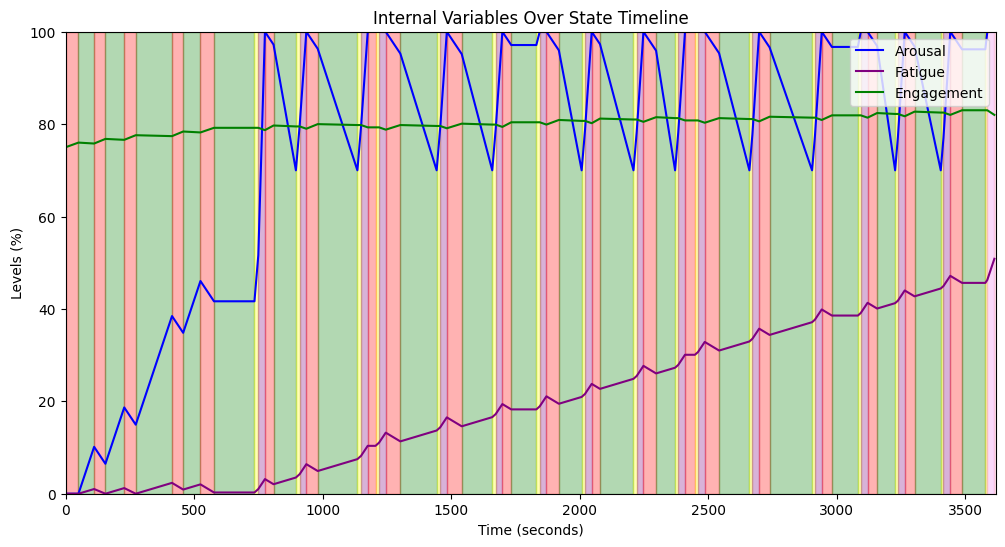

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random

# Constants
MAX_VALUE = 100
TOTAL_DURATION = 3600  # Target total duration in seconds (1 hour)
MIN_DURATION = 3000    # Minimum duration before the finale sequence
MAX_DURATION = 4200    # Maximum duration after which the finale must occur

# State Duration Ranges (in seconds)
STATE_DURATIONS = {
    'RED': (30, 60),
    'GREEN': (60, 180),
    'YELLOW': (5, 15),
    'PURPLE': (10, 30),
    'YELLOW_FINAL': (5, 10),
    'PURPLE_FINAL': (15, 30),
    'PINK': (5, 5)  # Fixed duration
}

# Initial Variables
A = 0.0   # Arousal (0 to 100)
F = 0.0   # Fatigue (0 to 100)
E = 75.0  # Engagement (0 to 100)

# Scheduled 'PURPLE' times (in seconds)
scheduled_purple_times = [600, 1200, 1800, 2400, 3000]  # Every 10 minutes

# Helper Functions
def get_random_duration(state, internal_vars):
    min_duration, max_duration = STATE_DURATIONS[state]
    if state in ['PURPLE', 'PURPLE_FINAL']:
        # 'PURPLE' duration based on Engagement
        engagement_factor = internal_vars['Engagement'] / MAX_VALUE
        duration = min_duration + (max_duration - min_duration) * engagement_factor
    elif state in ['YELLOW', 'YELLOW_FINAL']:
        # 'YELLOW' duration inversely based on Fatigue
        fatigue_factor = internal_vars['Fatigue'] / MAX_VALUE
        duration = max_duration - (max_duration - min_duration) * fatigue_factor
    else:
        duration = random.uniform(min_duration, max_duration)
    return duration

def sigmoid(x, x0, k):
    return 1 / (1 + np.exp(-k * (x - x0)))

# State Machine Function
def next_state(current_state, internal_vars):
    global time_elapsed, scheduled_purple_times, finish_condition_met
    
    A = internal_vars['Arousal']
    F = internal_vars['Fatigue']
    E = internal_vars['Engagement']
    
    # Check if finish condition is met
    if not finish_condition_met and time_elapsed >= MIN_DURATION:
        # Probability to start the finale sequence increases over time
        p = sigmoid(time_elapsed, TOTAL_DURATION, 0.01)
        if random.random() < p or time_elapsed >= MAX_DURATION:
            finish_condition_met = True
            return 'YELLOW_FINAL', internal_vars, get_random_duration('YELLOW_FINAL', internal_vars)
    
    # Check for scheduled 'PURPLE' state
    if scheduled_purple_times and time_elapsed >= scheduled_purple_times[0]:
        if current_state not in ['PURPLE', 'YELLOW']:
            # Transition to 'YELLOW' to prepare for 'PURPLE'
            scheduled_purple_times.pop(0)
            return 'YELLOW', internal_vars, get_random_duration('YELLOW', internal_vars)
    
    # Define fatigue and arousal increase/decrease rates
    if current_state == 'RED':
        # Recover fatigue and decrease arousal
        F_decrease_rate = 2  # Adjusted to slow down fatigue decrease
        F = max(F - F_decrease_rate * internal_vars['Duration'] / 60, 0)
        A_decrease_rate = 5  # Adjusted to slow down arousal decrease
        A = max(A - A_decrease_rate * internal_vars['Duration'] / 60, 0)
        E = min(E + 1, MAX_VALUE)  # Slightly increase engagement during rest
        duration = random.uniform(*STATE_DURATIONS['RED'])
        return 'GREEN', {'Arousal': A, 'Fatigue': F, 'Engagement': E}, duration
    
    elif current_state == 'GREEN':
        # Increase arousal and fatigue
        A_increase_rate = 10  # Adjusted rate
        A = min(A + A_increase_rate * internal_vars['Duration'] / 60, 70)  # Cap at threshold before 'YELLOW'
        F_increase_rate = 1  # Adjusted rate
        F = min(F + F_increase_rate * internal_vars['Duration'] / 60, MAX_VALUE)
        E = max(E - 0.2, 0)  # Slightly decrease engagement over time
        duration = random.uniform(*STATE_DURATIONS['GREEN'])
        # Transition to 'RED' if fatigue too high
        if F >= 80:
            return 'RED', {'Arousal': A, 'Fatigue': F, 'Engagement': E}, duration
        # Transition to 'YELLOW' if arousal high enough
        elif A >= 70:
            return 'YELLOW', {'Arousal': A, 'Fatigue': F, 'Engagement': E}, get_random_duration('YELLOW', internal_vars)
        else:
            # Transition to 'RED' to prevent 'GREEN' looping
            return 'RED', {'Arousal': A, 'Fatigue': F, 'Engagement': E}, duration
    
    elif current_state == 'YELLOW':
        # Quickly increase arousal to edge
        A_increase_rate = 40  # Fast increase
        A = min(A + A_increase_rate * internal_vars['Duration'] / 60, MAX_VALUE)
        F_increase_rate = 3  # Fatigue increases due to effort
        F = min(F + F_increase_rate * internal_vars['Duration'] / 60, MAX_VALUE)
        duration = get_random_duration('YELLOW', internal_vars)
        return 'PURPLE', {'Arousal': A, 'Fatigue': F, 'Engagement': E}, get_random_duration('PURPLE', internal_vars)
    
    elif current_state == 'PURPLE':
        # Maintain arousal at 100%, fatigue increases
        F_increase_rate = 5  # Fatigue increases
        F = min(F + F_increase_rate * internal_vars['Duration'] / 60, MAX_VALUE)
        A = MAX_VALUE  # At edge
        E = max(E - 0.5, 0)  # Engagement may decrease due to strain
        duration = get_random_duration('PURPLE', internal_vars)
        return 'RED', {'Arousal': A, 'Fatigue': F, 'Engagement': E}, duration
    
    elif current_state == 'YELLOW_FINAL':
        # Final build-up to edge
        A_increase_rate = 60  # Very fast increase
        A = min(A + A_increase_rate * internal_vars['Duration'] / 60, MAX_VALUE)
        F_increase_rate = 5
        F = min(F + F_increase_rate * internal_vars['Duration'] / 60, MAX_VALUE)
        duration = get_random_duration('YELLOW_FINAL', internal_vars)
        return 'PURPLE_FINAL', {'Arousal': A, 'Fatigue': F, 'Engagement': E}, get_random_duration('PURPLE_FINAL', internal_vars)
    
    elif current_state == 'PURPLE_FINAL':
        # Final edge before release
        F_increase_rate = 10  # Max fatigue increase
        F = min(F + F_increase_rate * internal_vars['Duration'] / 60, MAX_VALUE)
        A = MAX_VALUE
        E = max(E - 1, 0)
        duration = get_random_duration('PURPLE_FINAL', internal_vars)
        return 'PINK', {'Arousal': A, 'Fatigue': F, 'Engagement': E}, STATE_DURATIONS['PINK'][0]
    
    elif current_state == 'PINK':
        # End state
        duration = STATE_DURATIONS['PINK'][0]
        return None, internal_vars, duration

    # Default transition
    duration = random.uniform(*STATE_DURATIONS['RED'])
    return 'RED', {'Arousal': A, 'Fatigue': F, 'Engagement': E}, duration

# Initialize variables
current_state = 'RED'
timeline = []
emotions = []
time_elapsed = 0
finish_condition_met = False  # Flag to indicate if finish condition has been met

# Initial internal variables
internal_vars = {'Arousal': A, 'Fatigue': F, 'Engagement': E, 'Duration': 0}

while current_state is not None and time_elapsed < MAX_DURATION:
    # Set the duration of the current state
    duration = get_random_duration(current_state, internal_vars)
    internal_vars['Duration'] = duration

    # Append to timeline and emotions before updating internal_vars
    timeline.append({'state': current_state, 'start_time': time_elapsed, 'duration': duration})
    emotions.append({'time': time_elapsed, 'Arousal': internal_vars['Arousal'], 'Fatigue': internal_vars['Fatigue'], 'Engagement': internal_vars['Engagement']})
    
    # Update time elapsed
    time_elapsed += duration

    # Get next state and updated internal variables
    next_state_name, updated_vars, _ = next_state(current_state, internal_vars)
    internal_vars = updated_vars

    # Transition to next state
    current_state = next_state_name
    
# Define color mapping for states
color_map = {
    'RED': 'red',
    'GREEN': 'green',
    'YELLOW': 'yellow',
    'PURPLE': 'purple',
    'YELLOW_FINAL': 'gold',
    'PURPLE_FINAL': 'violet',
    'PINK': 'pink'
}

# Define times based on emotions' recorded times
times = [e['time'] for e in emotions]

# Visualization of the timeline and internal variables
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the state timeline as background color bars
for segment in timeline:
    color = color_map.get(segment['state'], 'gray')
    start = segment['start_time']
    duration = segment['duration']
    ax1.add_patch(mpatches.Rectangle((start, 0), duration, 100, color=color, alpha=0.3))

# Plot the internal variable levels on top of the timeline
ax1.plot(times, [e['Arousal'] for e in emotions], label='Arousal', color='blue', linewidth=1.5)
ax1.plot(times, [e['Fatigue'] for e in emotions], label='Fatigue', color='purple', linewidth=1.5)
ax1.plot(times, [e['Engagement'] for e in emotions], label='Engagement', color='green', linewidth=1.5)

# Add labels and legend
ax1.set_xlim(0, time_elapsed)
ax1.set_ylim(0, 100)
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("Levels (%)")
ax1.legend(loc="upper right")
plt.title('Internal Variables Over State Timeline')

plt.show()

In [9]:
timeline

[{'state': 'RED', 'start_time': 0.0, 'duration': 32.57237514623305},
 {'state': 'GREEN',
  'start_time': 32.57237514623304,
  'duration': 93.59813777060583},
 {'state': 'GREEN',
  'start_time': 126.17051291683886,
  'duration': 121.08687811592885},
 {'state': 'GREEN',
  'start_time': 247.25739103276769,
  'duration': 82.02303200142777},
 {'state': 'GREEN',
  'start_time': 329.28042303419545,
  'duration': 172.38218722340574},
 {'state': 'GREEN',
  'start_time': 501.66261025760116,
  'duration': 151.0643958161212},
 {'state': 'GREEN',
  'start_time': 652.7270060737224,
  'duration': 13.970258681754462},
 {'state': 'YELLOW',
  'start_time': 666.6972647554768,
  'duration': 24.395106903883836},
 {'state': 'PURPLE',
  'start_time': 691.0923716593607,
  'duration': 15.254566550172388},
 {'state': 'RED',
  'start_time': 706.346938209533,
  'duration': 54.50111313434363},
 {'state': 'GREEN',
  'start_time': 760.8480513438767,
  'duration': 5.551057973035731},
 {'state': 'YELLOW',
  'start_tim